### Libraries ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
from category_encoders import BinaryEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
import lightgbm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read The Data ###

In [2]:
try:
    train_csv = pd.read_csv('Data/train.csv')
    test_csv = pd.read_csv('Data/test.csv')
    sample_solution = pd.read_csv('Data/sample_solution.csv')
except Exception:
    print('Check your path input. ..!')

What exactly the busnisess objective is?
- Creating model to predict building energy consumption .

About The DataSet:
- The variables describe building characteristics and climate and ((weather) for the regions in which the buildings are located).
- The feature we need to predict: (site_eui) it should be a real value.

Note: I will use the (RMSE) for a single column (for the evaluation)

- The Model will be supervised (Regression), Batch Learning.

In [3]:
train_csv.head()

Year_Factor State_Factor building_class  \
0            1      State_1     Commercial   
1            1      State_1     Commercial   
2            1      State_1     Commercial   
3            1      State_1     Commercial   
4            1      State_1     Commercial   

                               facility_type  floor_area  year_built  \
0               Grocery_store_or_food_market     61242.0      1942.0   
1  Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                       Retail_Enclosed_mall    280025.0      1951.0   
3                  Education_Other_classroom     55325.0      1980.0   
4                  Warehouse_Nonrefrigerated     66000.0      1985.0   

   energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  ...  \
0                11.0        2.4                36              50.5  ...   
1                45.0        1.8                36              50.5  ...   
2                97.0        1.8                36              50.5  ...   
3                46.0        1.8                36              50.5  ...   
4               100.0        2.4                36              50.5  ...   

   days_above_80F  days_above_90F  days_above_100F  days_above_110F  \
0              14               0                0                0   
1              14               0                0                0   
2              14               0                0                0   
3              14               0                0                0   
4              14               0                0                0   

   direction_max_wind_speed  direction_peak_wind_speed  max_wind_speed  \
0                       1.0                        1.0             1.0   
1                       1.0                        NaN             1.0   
2                       1.0                        NaN             1.0   
3                       1.0                        NaN             1.0   
4                       1.0                        1.0             1.0   

   days_with_fog    site_eui  id  
0            NaN  248.682615   0  
1           12.0   26.500150   1  
2           12.0   24.693619   2  
3           12.0   48.406926   3  
4            NaN    3.899395   4  

[5 rows x 64 columns]

In [4]:
test_csv.head()

Year_Factor State_Factor building_class                 facility_type  \
0            7      State_1     Commercial  Grocery_store_or_food_market   
1            7      State_1     Commercial  Grocery_store_or_food_market   
2            7      State_1     Commercial  Grocery_store_or_food_market   
3            7      State_1     Commercial  Grocery_store_or_food_market   
4            7      State_1     Commercial  Grocery_store_or_food_market   

   floor_area  year_built  energy_star_rating  ELEVATION  january_min_temp  \
0     28484.0      1994.0                37.0        2.4                38   
1     21906.0      1961.0                55.0       45.7                38   
2     16138.0      1950.0                 1.0       59.1                38   
3     97422.0      1971.0                34.0       35.4                38   
4     61242.0      1942.0                35.0        1.8                38   

   january_avg_temp  ...  days_below_0F  days_above_80F  days_above_90F  \
0         50.596774  ...              0              29               5   
1         50.596774  ...              0              29               5   
2         50.596774  ...              0              29               5   
3         50.596774  ...              0              29               5   
4         50.596774  ...              0              29               5   

   days_above_100F  days_above_110F  direction_max_wind_speed  \
0                2                0                       NaN   
1                2                0                       NaN   
2                2                0                       NaN   
3                2                0                       NaN   
4                2                0                     340.0   

   direction_peak_wind_speed  max_wind_speed  days_with_fog     id  
0                        NaN             NaN            NaN  75757  
1                        NaN             NaN            NaN  75758  
2                        NaN             NaN            NaN  75759  
3                        NaN             NaN            NaN  75760  
4                      330.0            22.8          126.0  75761  

[5 rows x 63 columns]

In [5]:
print('Train shape: ', train_csv.shape)
print('Test shape: ', test_csv.shape)

Train shape:  (75757, 64)
Test shape:  (9705, 63)


In [6]:
print('The Trget: ', set(train_csv.columns.to_list()) - set(test_csv.columns.to_list()))

The Trget:  {'site_eui'}


In [7]:
train_csv.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [8]:
train_csv.dtypes.value_counts()

int64      37
float64    24
object      3
dtype: int64

In [9]:
# train_csv.where(train_csv.dtypes == 'object')
col_dty = train_csv.dtypes.to_frame(name='Dtypes')
print('Object columns: \n', col_dty[col_dty['Dtypes']=='object'])
print('=========================================')
print('Int64 columns: \n', col_dty[col_dty['Dtypes']=='int64'])
print('=========================================')
print('float64 columns: \n', col_dty[col_dty['Dtypes']=='float64'])

Object columns: 
                 Dtypes
State_Factor    object
building_class  object
facility_type   object
Int64 columns: 
                     Dtypes
Year_Factor          int64
january_min_temp     int64
january_max_temp     int64
february_min_temp    int64
february_max_temp    int64
march_min_temp       int64
march_max_temp       int64
april_min_temp       int64
april_max_temp       int64
may_min_temp         int64
may_max_temp         int64
june_min_temp        int64
june_max_temp        int64
july_min_temp        int64
july_max_temp        int64
august_min_temp      int64
august_max_temp      int64
september_min_temp   int64
september_max_temp   int64
october_min_temp     int64
october_max_temp     int64
november_min_temp    int64
november_max_temp    int64
december_min_temp    int64
december_max_temp    int64
cooling_degree_days  int64
heating_degree_days  int64
snowdepth_inches     int64
days_below_30F       int64
days_below_20F       int64
days_below_10F       int64
days_belo

### Data Analysis ###

### Part 1 ###
- (('Year_Factor', 'State_Factor',))
   (('cooling_degree_days','heating_degree_days',))
   (('precipitation_inches', 'snowfall_inches','snowdepth_inches',))
   (('direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed',))
   'building_class', 'facility_type',
   'floor_area', 'year_built', 'energy_star_rating','ELEVATION','avg_temp','days_with_fog', 'id'
- The Trget : 'site_eui'
- size: 20 features

In [10]:
train_csv[['id','Year_Factor','floor_area', 'year_built', 'energy_star_rating', 'ELEVATION', 'cooling_degree_days',
          'heating_degree_days','precipitation_inches', 'snowfall_inches',
           'snowdepth_inches', 'avg_temp','direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog','site_eui' ]].describe().T

count           mean            std         min  \
id                         75757.0   37878.000000   21869.306509    0.000000   
Year_Factor                75757.0       4.367755       1.471441    1.000000   
floor_area                 75757.0  165983.865858  246875.790940  943.000000   
year_built                 73920.0    1952.306764      37.053619    0.000000   
energy_star_rating         49048.0      61.048605      28.663683    0.000000   
ELEVATION                  75757.0      39.506323      60.656596   -6.400000   
cooling_degree_days        75757.0    1202.250446     391.561780    0.000000   
heating_degree_days        75757.0    4324.957390     824.366727  398.000000   
precipitation_inches       75757.0      42.430651      10.592205    0.000000   
snowfall_inches            75757.0      29.136379      17.810894    0.000000   
snowdepth_inches           75757.0     164.862455     175.275869    0.000000   
avg_temp                   75757.0      56.176705       2.241940   44.512329   
direction_max_wind_speed   34675.0      66.552675     131.147834    1.000000   
direction_peak_wind_speed  33946.0      62.779974     130.308106    1.000000   
max_wind_speed             34675.0       4.190601       6.458789    1.000000   
days_with_fog              29961.0     109.142051      50.699751   12.000000   
site_eui                   75757.0      82.584693      58.255403    1.001169   

                                    25%           50%            75%  \
id                         18939.000000  37878.000000   56817.000000   
Year_Factor                    3.000000      5.000000       6.000000   
floor_area                 62379.000000  91367.000000  166000.000000   
year_built                  1927.000000   1951.000000    1977.000000   
energy_star_rating            40.000000     67.000000      85.000000   
ELEVATION                     11.900000     25.000000      42.700000   
cooling_degree_days         1128.000000   1277.000000    1489.000000   
heating_degree_days         3978.000000   4337.000000    4670.000000   
precipitation_inches          39.350000     42.170000      46.320000   
snowfall_inches                9.600000     31.600000      49.100000   
snowdepth_inches              10.000000    101.000000     377.000000   
avg_temp                      55.147541     56.835616      57.215847   
direction_max_wind_speed       1.000000      1.000000       1.000000   
direction_peak_wind_speed      1.000000      1.000000       1.000000   
max_wind_speed                 1.000000      1.000000       1.000000   
days_with_fog                 88.000000    104.000000     131.000000   
site_eui                      54.528601     75.293716      97.277534   

                                    max  
id                         7.575600e+04  
Year_Factor                6.000000e+00  
floor_area                 6.385382e+06  
year_built                 2.015000e+03  
energy_star_rating         1.000000e+02  
ELEVATION                  1.924500e+03  
cooling_degree_days        4.948000e+03  
heating_degree_days        7.929000e+03  
precipitation_inches       1.076900e+02  
snowfall_inches            1.273000e+02  
snowdepth_inches           1.292000e+03  
avg_temp                   7.724521e+01  
direction_max_wind_speed   3.600000e+02  
direction_peak_wind_speed  3.600000e+02  
max_wind_speed             2.330000e+01  
days_with_fog              3.110000e+02  
site_eui                   9.978661e+02

In [11]:
train_csv[['id','Year_Factor','floor_area', 'year_built', 'energy_star_rating', 'ELEVATION', 'cooling_degree_days',
          'heating_degree_days','precipitation_inches', 'snowfall_inches',
           'snowdepth_inches', 'avg_temp','direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog','site_eui' ]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         75757 non-null  int64  
 1   Year_Factor                75757 non-null  int64  
 2   floor_area                 75757 non-null  float64
 3   year_built                 73920 non-null  float64
 4   energy_star_rating         49048 non-null  float64
 5   ELEVATION                  75757 non-null  float64
 6   cooling_degree_days        75757 non-null  int64  
 7   heating_degree_days        75757 non-null  int64  
 8   precipitation_inches       75757 non-null  float64
 9   snowfall_inches            75757 non-null  float64
 10  snowdepth_inches           75757 non-null  int64  
 11  avg_temp                   75757 non-null  float64
 12  direction_max_wind_speed   34675 non-null  float64
 13  direction_peak_wind_speed  33946 non-null  flo

In [12]:
train_csv[['State_Factor', 'building_class', 'facility_type']].describe(include='O').T

count unique                        top   freq
State_Factor    75757      7                    State_6  50840
building_class  75757      2                Residential  43558
facility_type   75757     60  Multifamily_Uncategorized  39455

In [13]:
train_csv[['State_Factor', 'building_class', 'facility_type']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   State_Factor    75757 non-null  object
 1   building_class  75757 non-null  object
 2   facility_type   75757 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [14]:
null_values = train_csv.isnull().sum().sort_values(ascending=False).to_frame(name='Null')
null_values[null_values['Null'] != 0]

Null
days_with_fog              45796
direction_peak_wind_speed  41811
max_wind_speed             41082
direction_max_wind_speed   41082
energy_star_rating         26709
year_built                  1837

In [15]:
back_up_train_data = train_csv.copy()

In [16]:
train_csv.drop(['direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog'], axis=1, inplace=True)

In [17]:
corr = train_csv.corr()
corr['energy_star_rating'].sort_values(ascending=False)

energy_star_rating      1.000000
january_avg_temp        0.149421
january_min_temp        0.144452
february_avg_temp       0.137479
march_avg_temp          0.137160
march_min_temp          0.134648
february_min_temp       0.126411
april_min_temp          0.105996
february_max_temp       0.104399
april_max_temp          0.101430
april_avg_temp          0.100951
november_min_temp       0.096028
avg_temp                0.086425
january_max_temp        0.081703
march_max_temp          0.077333
october_min_temp        0.076621
november_avg_temp       0.067282
days_above_100F         0.059382
june_max_temp           0.056200
october_avg_temp        0.049684
october_max_temp        0.037285
floor_area              0.034947
december_avg_temp       0.026105
december_min_temp       0.024659
days_above_90F          0.019541
may_max_temp            0.005743
Year_Factor            -0.005052
july_max_temp          -0.006585
november_max_temp      -0.012538
ELEVATION              -0.016783
days_below

In [18]:
train_csv['year_built'].unique()

array([1942., 1955., 1951., 1980., 1985., 1956., 1982., 1947., 1929.,
       1979., 1927., 1960., 1924.,   nan, 1949., 1926., 1914., 1973.,
       1900., 1913., 1962., 1989., 1967., 1954., 1986., 1906., 1912.,
       1902., 1920., 1905., 1997., 1909., 2002., 1974., 1907., 1908.,
       1988., 1987., 1923., 1948., 1966., 1975., 1934., 1938., 1983.,
       2003., 1915., 1961., 1911., 1925., 1964., 1953., 1957., 2006.,
       1990., 1991., 1969., 1968., 1910., 1937., 1971., 1965., 1946.,
       1917., 1901., 2000., 2008., 1999., 1981., 2001., 1978., 1898.,
       1928., 1970., 1918., 1930., 1903., 1936., 1921., 1922., 1984.,
       1976., 1952., 1959., 1916., 1963., 1972., 1919., 1931., 1958.,
          0., 1994., 1940., 2010., 2009., 1889., 1939., 1945., 1904.,
       1932., 1941., 1977., 1993., 1992., 1950., 1944., 1935., 1996.,
       1995., 1933., 1943., 2007., 2005., 2004., 1869., 2011., 2012.,
       1864., 1998., 1895., 1896., 1875., 1880., 1888., 1897., 1891.,
       2013., 1887.,

In [19]:
train_csv.year_built.value_counts()

1927.0    2064
1929.0    1999
1928.0    1979
1930.0    1811
1925.0    1710
          ... 
1878.0       1
1829.0       1
1844.0       1
1871.0       1
1815.0       1
Name: year_built, Length: 180, dtype: int64

In [20]:
train_csv.year_built.replace(0, np.nan, inplace=True)
train_csv.year_built.isnull().sum()

1843

In [21]:
train_csv = train_csv[train_csv.year_built.notna()]
train_csv['year_built'] = train_csv['year_built'].astype('int64')
print('Type of year_built column: ', train_csv.year_built.dtype)
print('Null Values in year_built: ', train_csv.year_built.isnull().sum())
print('new shape of train set: ', train_csv.shape)

Type of year_built column:  int64
Null Values in year_built:  0
new shape of train set:  (73914, 60)


In [22]:
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer.fit(train_csv[['energy_star_rating']])
train_csv['energy_star_rating'] = imputer.transform(train_csv[['energy_star_rating']])

In [23]:
train_csv.isnull().sum()

Year_Factor             0
State_Factor            0
building_class          0
facility_type           0
floor_area              0
year_built              0
energy_star_rating      0
ELEVATION               0
january_min_temp        0
january_avg_temp        0
january_max_temp        0
february_min_temp       0
february_avg_temp       0
february_max_temp       0
march_min_temp          0
march_avg_temp          0
march_max_temp          0
april_min_temp          0
april_avg_temp          0
april_max_temp          0
may_min_temp            0
may_avg_temp            0
may_max_temp            0
june_min_temp           0
june_avg_temp           0
june_max_temp           0
july_min_temp           0
july_avg_temp           0
july_max_temp           0
august_min_temp         0
august_avg_temp         0
august_max_temp         0
september_min_temp      0
september_avg_temp      0
september_max_temp      0
october_min_temp        0
october_avg_temp        0
october_max_temp        0
november_min

Target feature: 


<AxesSubplot:xlabel='site_eui'>

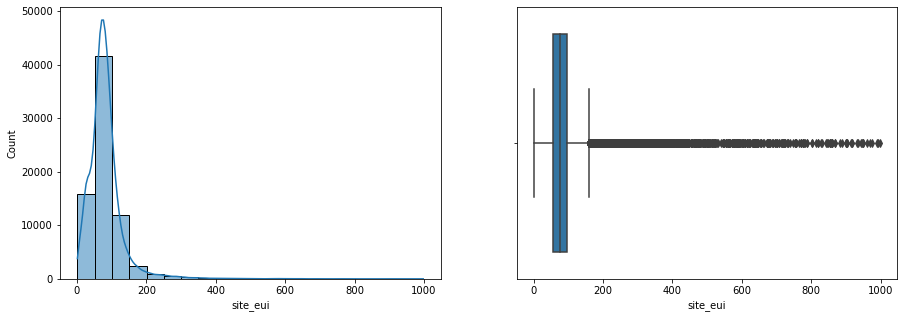

In [24]:
print('Target feature: ')
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=train_csv, x=train_csv.site_eui, bins=20, kde=True, ax=ax[0])
sns.boxplot(data=train_csv, x=train_csv.site_eui, ax=ax[1])

In [25]:
train_csv[['heating_degree_days','cooling_degree_days']].describe()

heating_degree_days  cooling_degree_days
count         73914.000000         73914.000000
mean           4351.179127          1201.973402
std             786.808283           385.793403
min            1427.000000            55.000000
25%            3978.000000          1128.000000
50%            4460.000000          1277.000000
75%            4670.000000          1489.000000
max            7929.000000          1999.000000

In [26]:
train_csv[['heating_degree_days','cooling_degree_days']].head()

heating_degree_days  cooling_degree_days
0                 2960                  115
1                 2960                  115
2                 2960                  115
3                 2960                  115
4                 2960                  115

In [27]:
train_csv['heating_degree_days'].unique()

array([2960, 2439, 2542, 3108, 1427, 1477, 1823, 2005, 4146, 3786, 4489,
       4760, 4337, 4138, 7157, 7027, 7339, 7929, 7580, 6070, 6049, 6213,
       6226, 6310, 5627, 5436, 5995, 4335, 3978, 3915, 4082, 4670, 5211,
       6569, 4875, 6071, 6933, 4460, 4913, 6607, 4252, 6105, 5331, 4614,
       5622, 5397, 5227, 5889, 5074, 5013, 3855, 3973, 3630, 3581, 3742,
       5401, 3772, 6218, 5853])

In [28]:
train_csv['cooling_degree_days'].unique()

array([ 115,  791,  826,  303,  643,  497, 1319,  142, 1631, 1509, 1306,
       1170, 1451, 1570,  707,  799,  744,  547,  650,  798,  814,  811,
        769, 1055, 1390,  986, 1331, 1277, 1430,  935, 1272,  957,  499,
       1128,  324, 1581, 1106,  441, 1489,  501, 1081, 1437,  884, 1063,
       1016,  808, 1114, 1168, 1719, 1712, 1999, 1994,  430,  297,  260,
         55,  148])

In [29]:
train_csv['cooling_heating_degree_days']= train_csv['cooling_degree_days']+train_csv['heating_degree_days']

In [30]:
len(train_csv['cooling_heating_degree_days'].unique())

59

In [31]:
train_csv['Year_Factor'].describe()

count    73914.000000
mean         4.397624
std          1.463808
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max          6.000000
Name: Year_Factor, dtype: float64

In [32]:
train_csv['Year_Factor'].value_counts()

6    22338
5    18208
4    12418
3    10366
2     8624
1     1960
Name: Year_Factor, dtype: int64

<AxesSubplot:xlabel='Year_Factor', ylabel='count'>

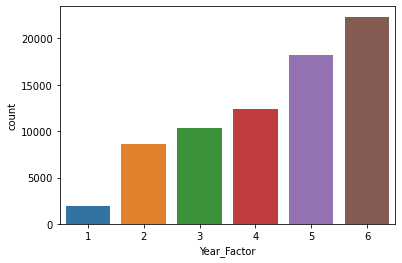

In [33]:
sns.countplot(data=train_csv, x=train_csv['Year_Factor'])

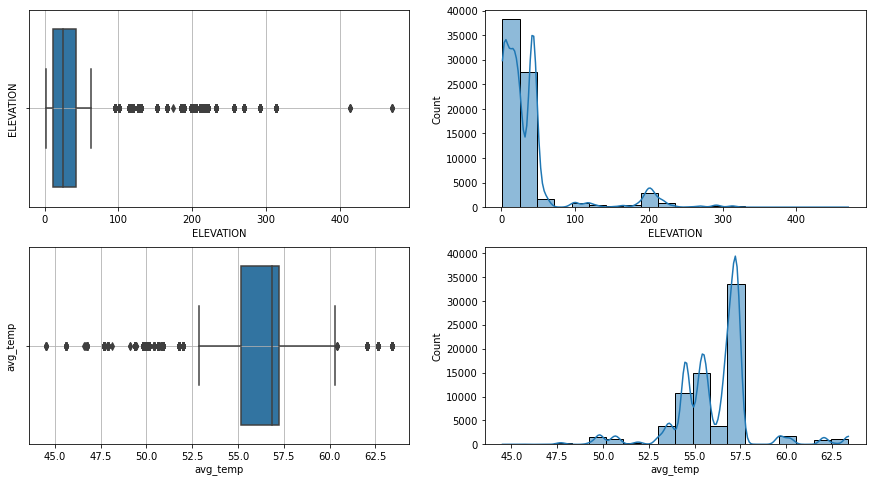

In [34]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
for count1, value in enumerate(['ELEVATION', 'avg_temp']):
    # visulaize box plot
    sns.boxplot(data=train_csv, x=train_csv[value], ax=ax[count1, 0])
    ax[count1, 0].set_ylabel(str(value))
    ax[count1, 0].grid()
    # visulaize histogram plot
    bins = len(train_csv[value].unique())//2
    sns.histplot(data=train_csv, x=train_csv[value], bins=20, kde=True, ax=ax[count1, 1])

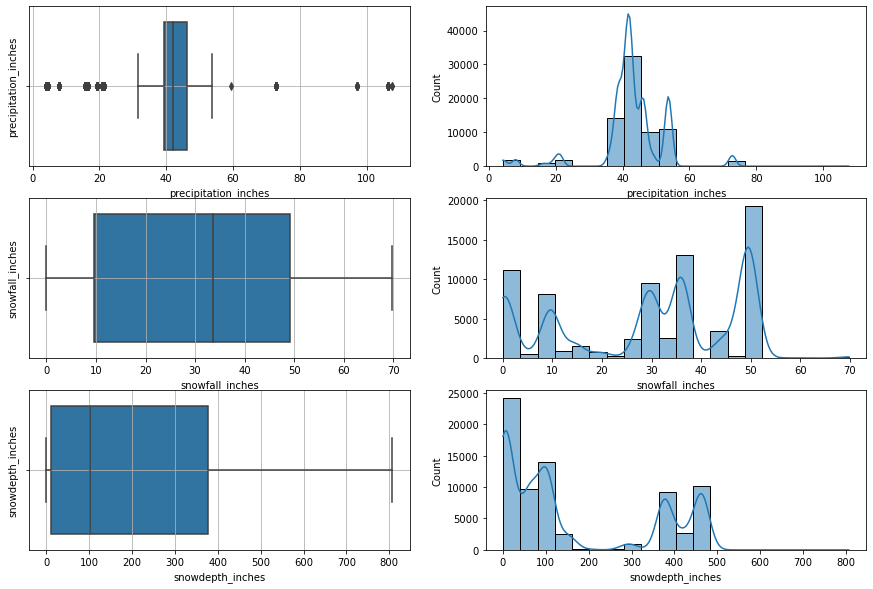

In [35]:
fig, ax = plt.subplots(3,2, figsize=(15,10))
for count1, value in enumerate(['precipitation_inches', 'snowfall_inches','snowdepth_inches']):
    # visulaize box plot
    sns.boxplot(data=train_csv, x=train_csv[value], ax=ax[count1, 0])
    ax[count1, 0].set_ylabel(str(value))
    ax[count1, 0].grid()
    # visulaize histogram plot
    bins = len(train_csv[value].unique())//2
    sns.histplot(data=train_csv, x=train_csv[value], bins=20, kde=True, ax=ax[count1, 1])

<AxesSubplot:>

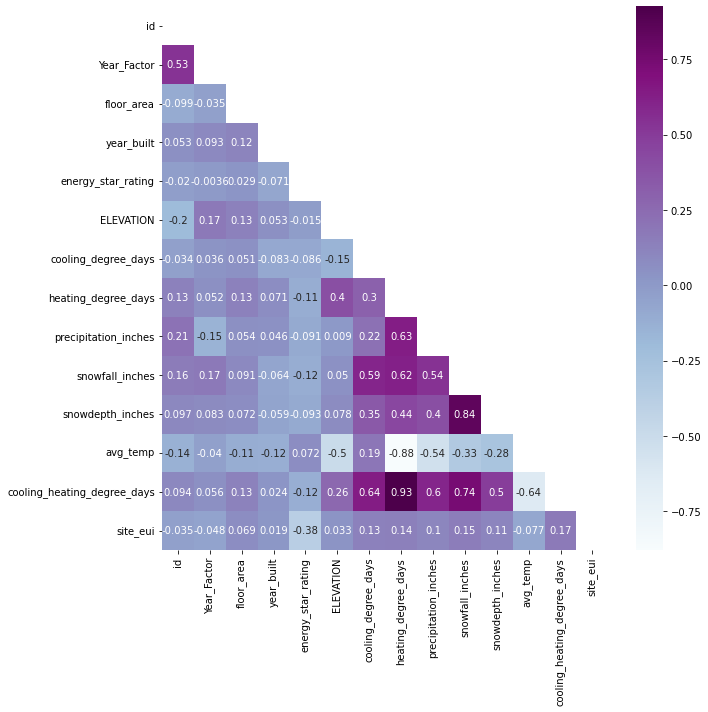

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
part1_corr = train_csv[['id','Year_Factor','floor_area', 'year_built', 'energy_star_rating', 'ELEVATION', 'cooling_degree_days',
          'heating_degree_days','precipitation_inches', 'snowfall_inches',
           'snowdepth_inches', 'avg_temp', 'cooling_heating_degree_days','site_eui']].corr()
matrix = np.triu(part1_corr)
sns.heatmap(part1_corr, annot=True, cmap="BuPu", mask=matrix)

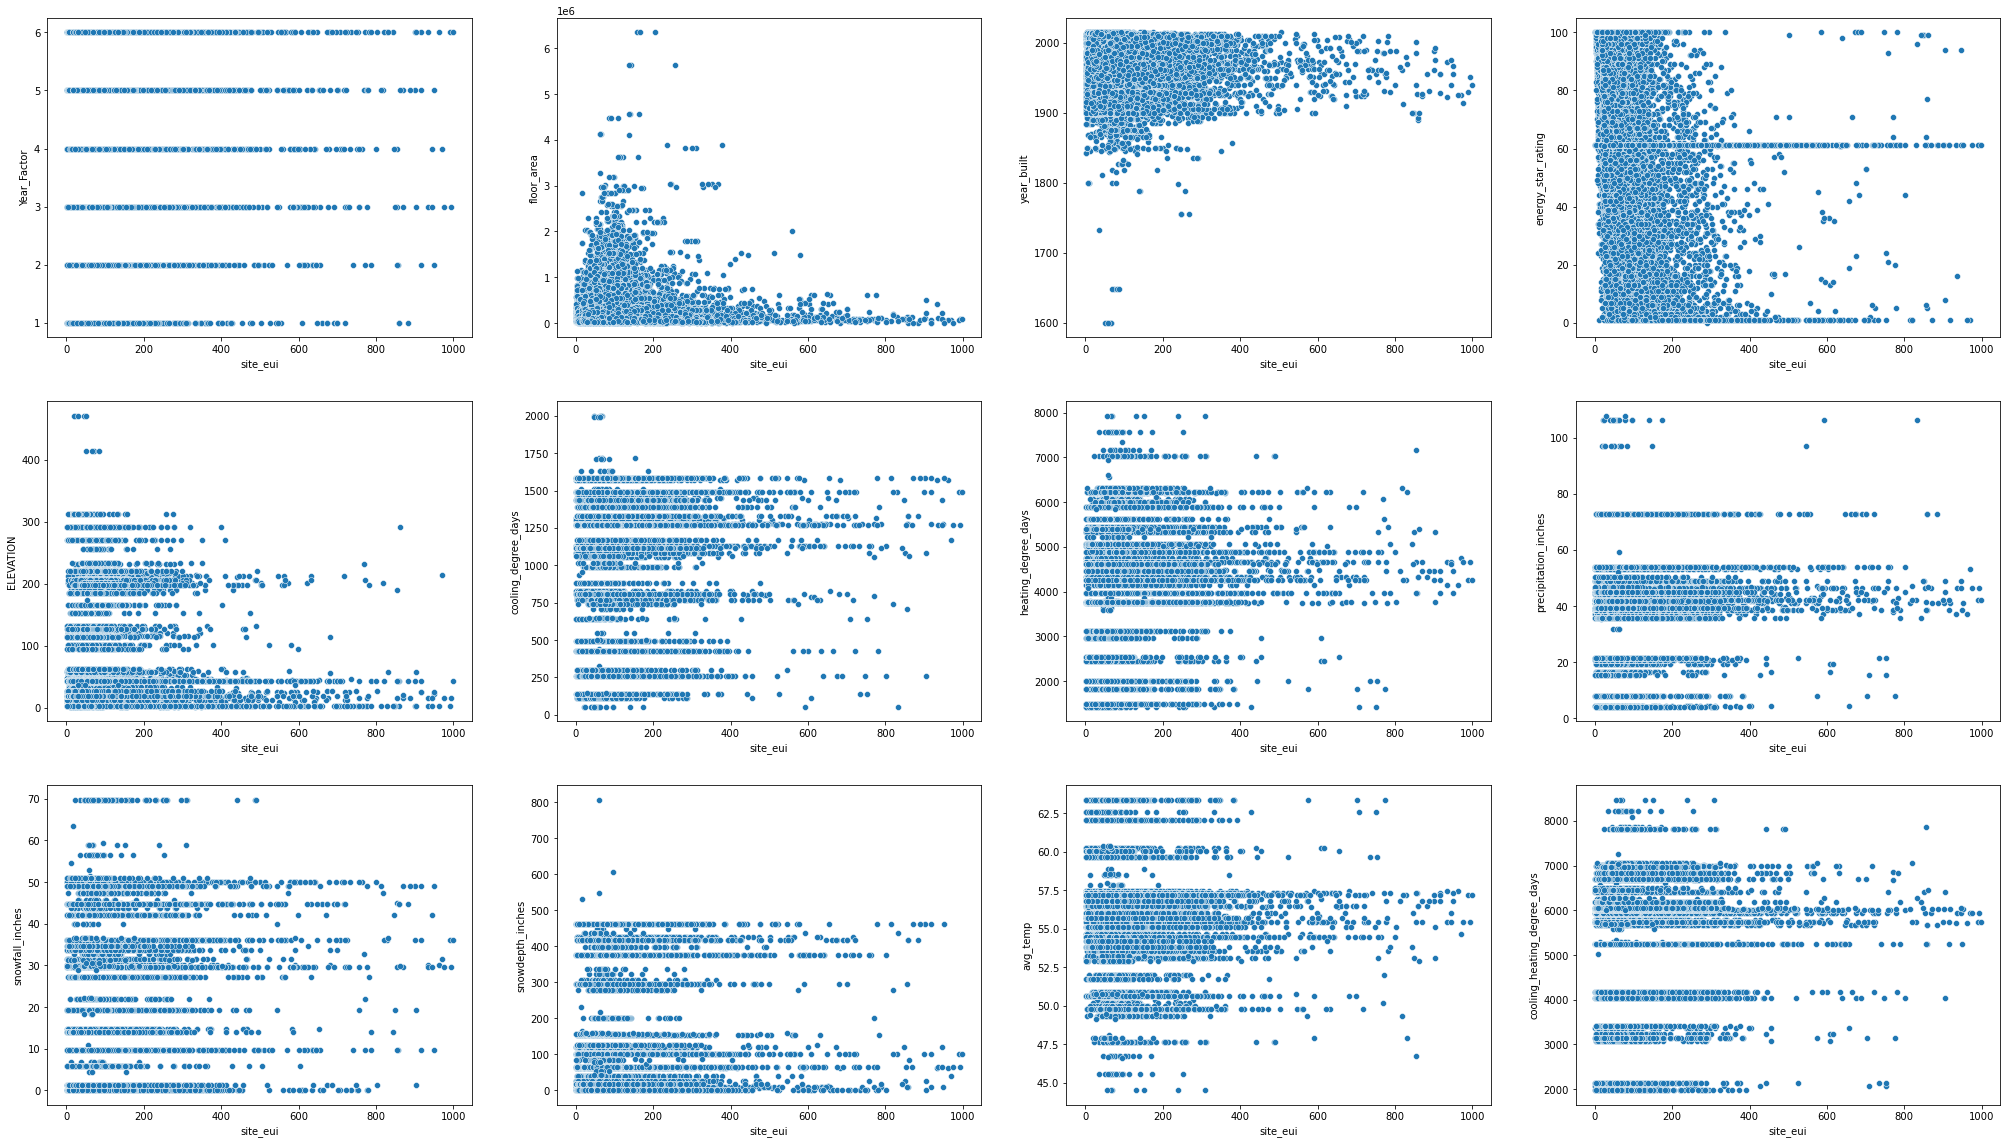

In [37]:
fig, ax = plt.subplots(3,4,figsize=(35,20))
part1_features = ['Year_Factor','floor_area', 'year_built', 'energy_star_rating', 'ELEVATION', 'cooling_degree_days',
          'heating_degree_days','precipitation_inches', 'snowfall_inches',
           'snowdepth_inches', 'avg_temp', 'cooling_heating_degree_days']
count1 = 0
count2 = 0
for pic in part1_features:
    sns.scatterplot(data=train_csv, x=train_csv['site_eui'], y=train_csv[pic] ,ax=ax[count1, count2])
    count2+=1
    if part1_features.index(pic) in [3,7, 11]:
        count1+=1
        count2=0
    if count1 == 3:
        break

### Part 2 ###
- 1- 'january_min_temp', 'january_avg_temp', 'january_max_temp',
- 2- 'february_min_temp', 'february_avg_temp', 'february_max_temp',
- 3- 'march_min_temp', 'march_avg_temp', 'march_max_temp', 
- 4- 'april_min_temp','april_avg_temp', 'april_max_temp', 
- 5- 'may_min_temp', 'may_avg_temp','may_max_temp'
- 6- 'june_min_temp', 'june_avg_temp', 'june_max_temp',
- 7- 'july_min_temp', 'july_avg_temp', 'july_max_temp',
- 8- 'august_min_temp','august_avg_temp', 'august_max_temp', 
- 9- 'september_min_temp','september_avg_temp', 'september_max_temp', 
- 10- 'october_min_temp','october_avg_temp', 'october_max_temp', 
- 11- 'november_min_temp','november_avg_temp', 'november_max_temp', 
- 12- 'december_min_temp','december_avg_temp', 'december_max_temp'

In [38]:
print('Minimum Temp in months:\n=============================================')
train_csv[['january_min_temp', 'february_min_temp', 'march_min_temp',
           'april_min_temp', 'may_min_temp', 'june_min_temp',
           'july_min_temp', 'august_min_temp', 'september_min_temp',
           'october_min_temp', 'november_min_temp', 'december_min_temp']].describe().T

Minimum Temp in months:


count       mean        std   min   25%   50%   75%  \
january_min_temp    73914.0  11.232067   9.190525 -19.0   6.0  11.0  13.0   
february_min_temp   73914.0  11.418933  12.449381 -13.0   2.0   9.0  20.0   
march_min_temp      73914.0  21.405593   9.880519  -9.0  12.0  25.0  27.0   
april_min_temp      73914.0  31.909760   5.502201  16.0  26.0  32.0  37.0   
may_min_temp        73914.0  44.658955   4.163534  32.0  42.0  45.0  49.0   
june_min_temp       73914.0  51.100346   3.384986  40.0  50.0  52.0  53.0   
july_min_temp       73914.0  60.607760   4.144163  48.0  58.0  63.0  63.0   
august_min_temp     73914.0  58.535271   4.434065  41.0  57.0  61.0  61.0   
september_min_temp  73914.0  50.787956   4.272979  37.0  47.0  52.0  54.0   
october_min_temp    73914.0  38.124117   5.014990  21.0  35.0  38.0  40.0   
november_min_temp   73914.0  28.526463   7.089394   4.0  22.0  31.0  34.0   
december_min_temp   73914.0  22.642165   9.022564 -10.0  17.0  24.0  28.0   

                     max  
january_min_temp    41.0  
february_min_temp   42.0  
march_min_temp      47.0  
april_min_temp      47.0  
may_min_temp        51.0  
june_min_temp       59.0  
july_min_temp       66.0  
august_min_temp     67.0  
september_min_temp  59.0  
october_min_temp    55.0  
november_min_temp   46.0  
december_min_temp   41.0

In [39]:
train_csv['year_min_avg']= (train_csv['january_min_temp']+ train_csv['february_min_temp']+ train_csv['march_min_temp']+
           train_csv['april_min_temp']+ train_csv['may_min_temp']+ train_csv['june_min_temp']+
           train_csv['july_min_temp']+ train_csv['august_min_temp']+ train_csv['september_min_temp']+
           train_csv['october_min_temp']+ train_csv['november_min_temp']+ train_csv['december_min_temp'])/12

In [40]:
print('Average Temp in months:\n=============================================')
train_csv[['january_avg_temp','february_avg_temp','march_avg_temp',
           'april_avg_temp','may_avg_temp','june_avg_temp',
           'july_avg_temp','august_avg_temp','september_avg_temp',
           'october_avg_temp','november_avg_temp','december_avg_temp']].describe().T

Average Temp in months:


count       mean       std        min        25%  \
january_avg_temp    73914.0  34.126456  6.785505  10.806452  29.827586   
february_avg_temp   73914.0  35.317891  8.736377  13.250000  31.625000   
march_avg_temp      73914.0  44.324794  6.535913  25.854839  38.096774   
april_avg_temp      73914.0  53.698518  2.356015  45.033333  52.333333   
may_avg_temp        73914.0  63.712960  2.763284  52.145161  62.790323   
june_avg_temp       73914.0  71.068098  2.816914  56.233333  70.983333   
july_avg_temp       73914.0  76.617288  4.038447  58.758065  76.145161   
august_avg_temp     73914.0  75.378317  3.789805  61.612903  74.516129   
september_avg_temp  73914.0  69.580827  3.593679  53.783333  68.200000   
october_avg_temp    73914.0  58.652671  2.521820  47.661290  58.048387   
november_avg_temp   73914.0  48.038293  3.962978  30.766667  45.250000   
december_avg_temp   73914.0  41.522583  5.807422  23.790323  38.532258   

                          50%        75%        max  
january_avg_temp    34.451613  37.322581  55.096774  
february_avg_temp   34.107143  40.879310  56.948276  
march_avg_temp      43.645161  49.354839  61.435484  
april_avg_temp      53.333333  54.766667  61.783333  
may_avg_temp        62.790323  65.096774  73.225806  
june_avg_temp       72.250000  72.450000  78.100000  
july_avg_temp       78.677419  78.790323  82.725806  
august_avg_temp     75.725806  78.967742  82.741935  
september_avg_temp  69.733333  71.800000  75.983333  
october_avg_temp    58.758065  59.629032  69.580645  
november_avg_temp   47.116667  51.283333  59.650000  
december_avg_temp   40.516129  43.435484  56.790323

In [41]:
train_csv['year_avg_avg']= (train_csv['january_avg_temp']+train_csv['february_avg_temp']+train_csv['march_avg_temp']+ 
train_csv['april_avg_temp']+train_csv['may_avg_temp']+train_csv['june_avg_temp']+
train_csv['july_avg_temp']+train_csv['august_avg_temp']+train_csv['september_avg_temp']+
train_csv['october_avg_temp']+train_csv['november_avg_temp']+train_csv['december_avg_temp'])/12

In [42]:
print('Maximum Temp in months:\n=============================================')
train_csv[['january_max_temp', 'february_max_temp', 'march_max_temp',
           'april_max_temp', 'may_max_temp', 'june_max_temp',
           'july_max_temp',  'august_max_temp', 'september_max_temp',
           'october_max_temp', 'november_max_temp', 'december_max_temp']].describe().T

Maximum Temp in months:


count       mean       std   min   25%   50%   75%  \
january_max_temp    73914.0  58.886206  5.090298  42.0  56.0  59.0  62.0   
february_max_temp   73914.0  58.262170  8.272523  38.0  55.0  61.0  62.0   
march_max_temp      73914.0  70.779284  7.622037  53.0  62.0  71.0  78.0   
april_max_temp      73914.0  82.581054  4.017689  70.0  80.0  82.0  86.0   
may_max_temp        73914.0  88.939903  2.751933  77.0  88.0  89.0  91.0   
june_max_temp       73914.0  91.324296  3.403445  81.0  89.0  90.0  94.0   
july_max_temp       73914.0  95.503396  4.028996  81.0  95.0  96.0  98.0   
august_max_temp     73914.0  92.555889  4.015407  76.0  90.0  91.0  95.0   
september_max_temp  73914.0  92.123157  4.974161  73.0  91.0  92.0  96.0   
october_max_temp    73914.0  81.009511  5.454605  59.0  78.0  80.0  85.0   
november_max_temp   73914.0  71.114390  4.221996  53.0  69.0  72.0  74.0   
december_max_temp   73914.0  64.404118  6.012656  42.0  60.0  65.0  71.0   

                      max  
january_max_temp     77.0  
february_max_temp    78.0  
march_max_temp       85.0  
april_max_temp       91.0  
may_max_temp         94.0  
june_max_temp       106.0  
july_max_temp       104.0  
august_max_temp     104.0  
september_max_temp  105.0  
october_max_temp    100.0  
november_max_temp    83.0  
december_max_temp    72.0

In [43]:
train_csv['year_max_avg']=(train_csv['january_max_temp']+ train_csv['february_max_temp']+ train_csv['march_max_temp']+
           train_csv['april_max_temp']+ train_csv['may_max_temp']+ train_csv['june_max_temp']+
           train_csv['july_max_temp']+  train_csv['august_max_temp']+ train_csv['september_max_temp']+
           train_csv['october_max_temp']+ train_csv['november_max_temp']+ train_csv['december_max_temp'])/12

<AxesSubplot:>

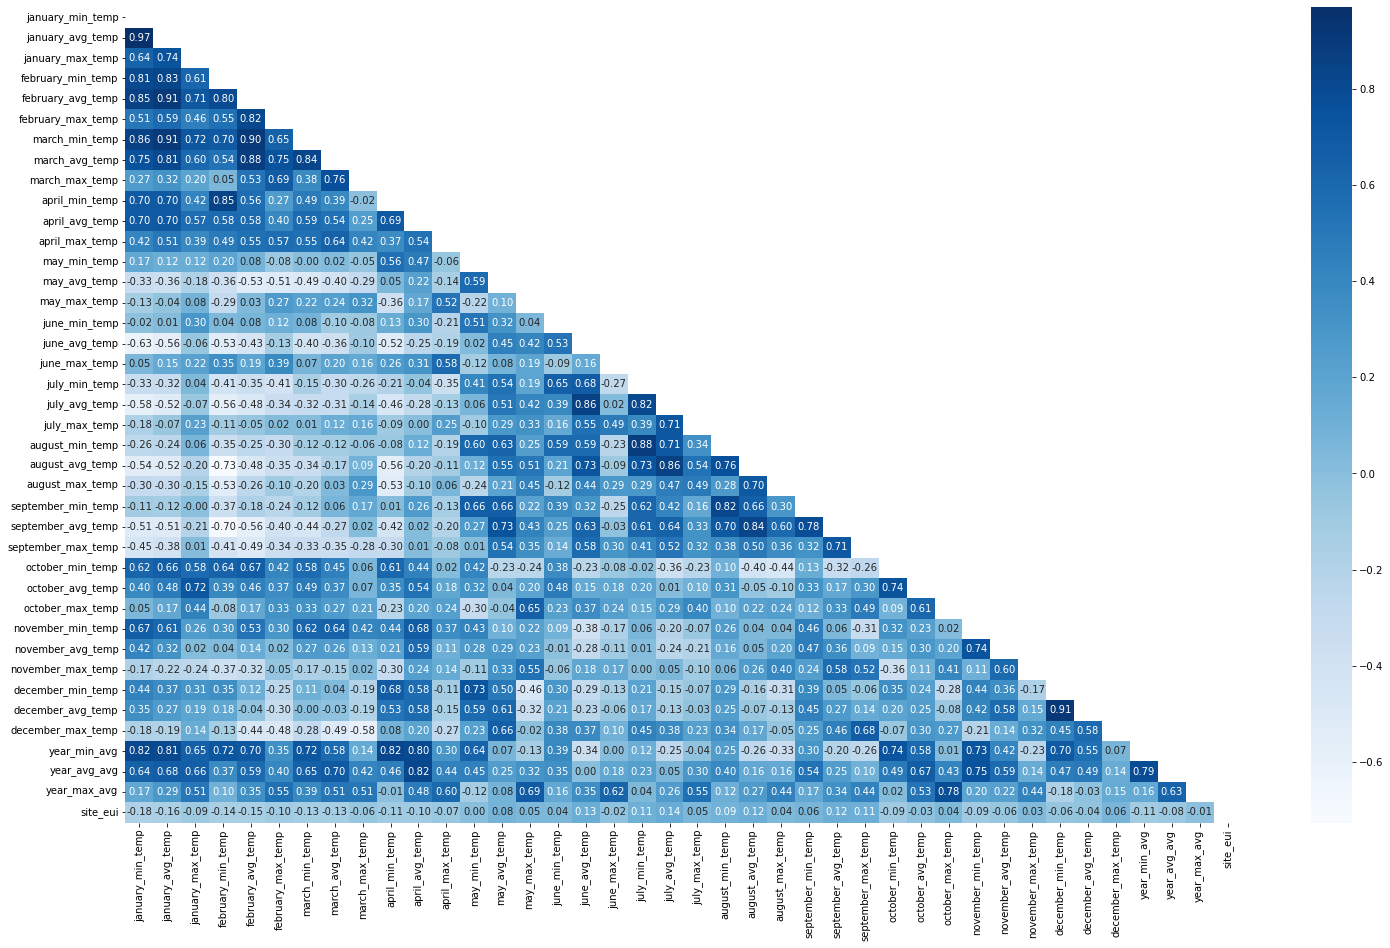

In [44]:
fig, ax = plt.subplots(figsize=(25,15))
part2_corr = train_csv[['january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp','year_min_avg', 'year_avg_avg', 'year_max_avg','site_eui']].corr()
matrix = np.triu(part2_corr)
sns.heatmap(part2_corr, annot=True, fmt='.2f',cmap="Blues", mask=matrix)

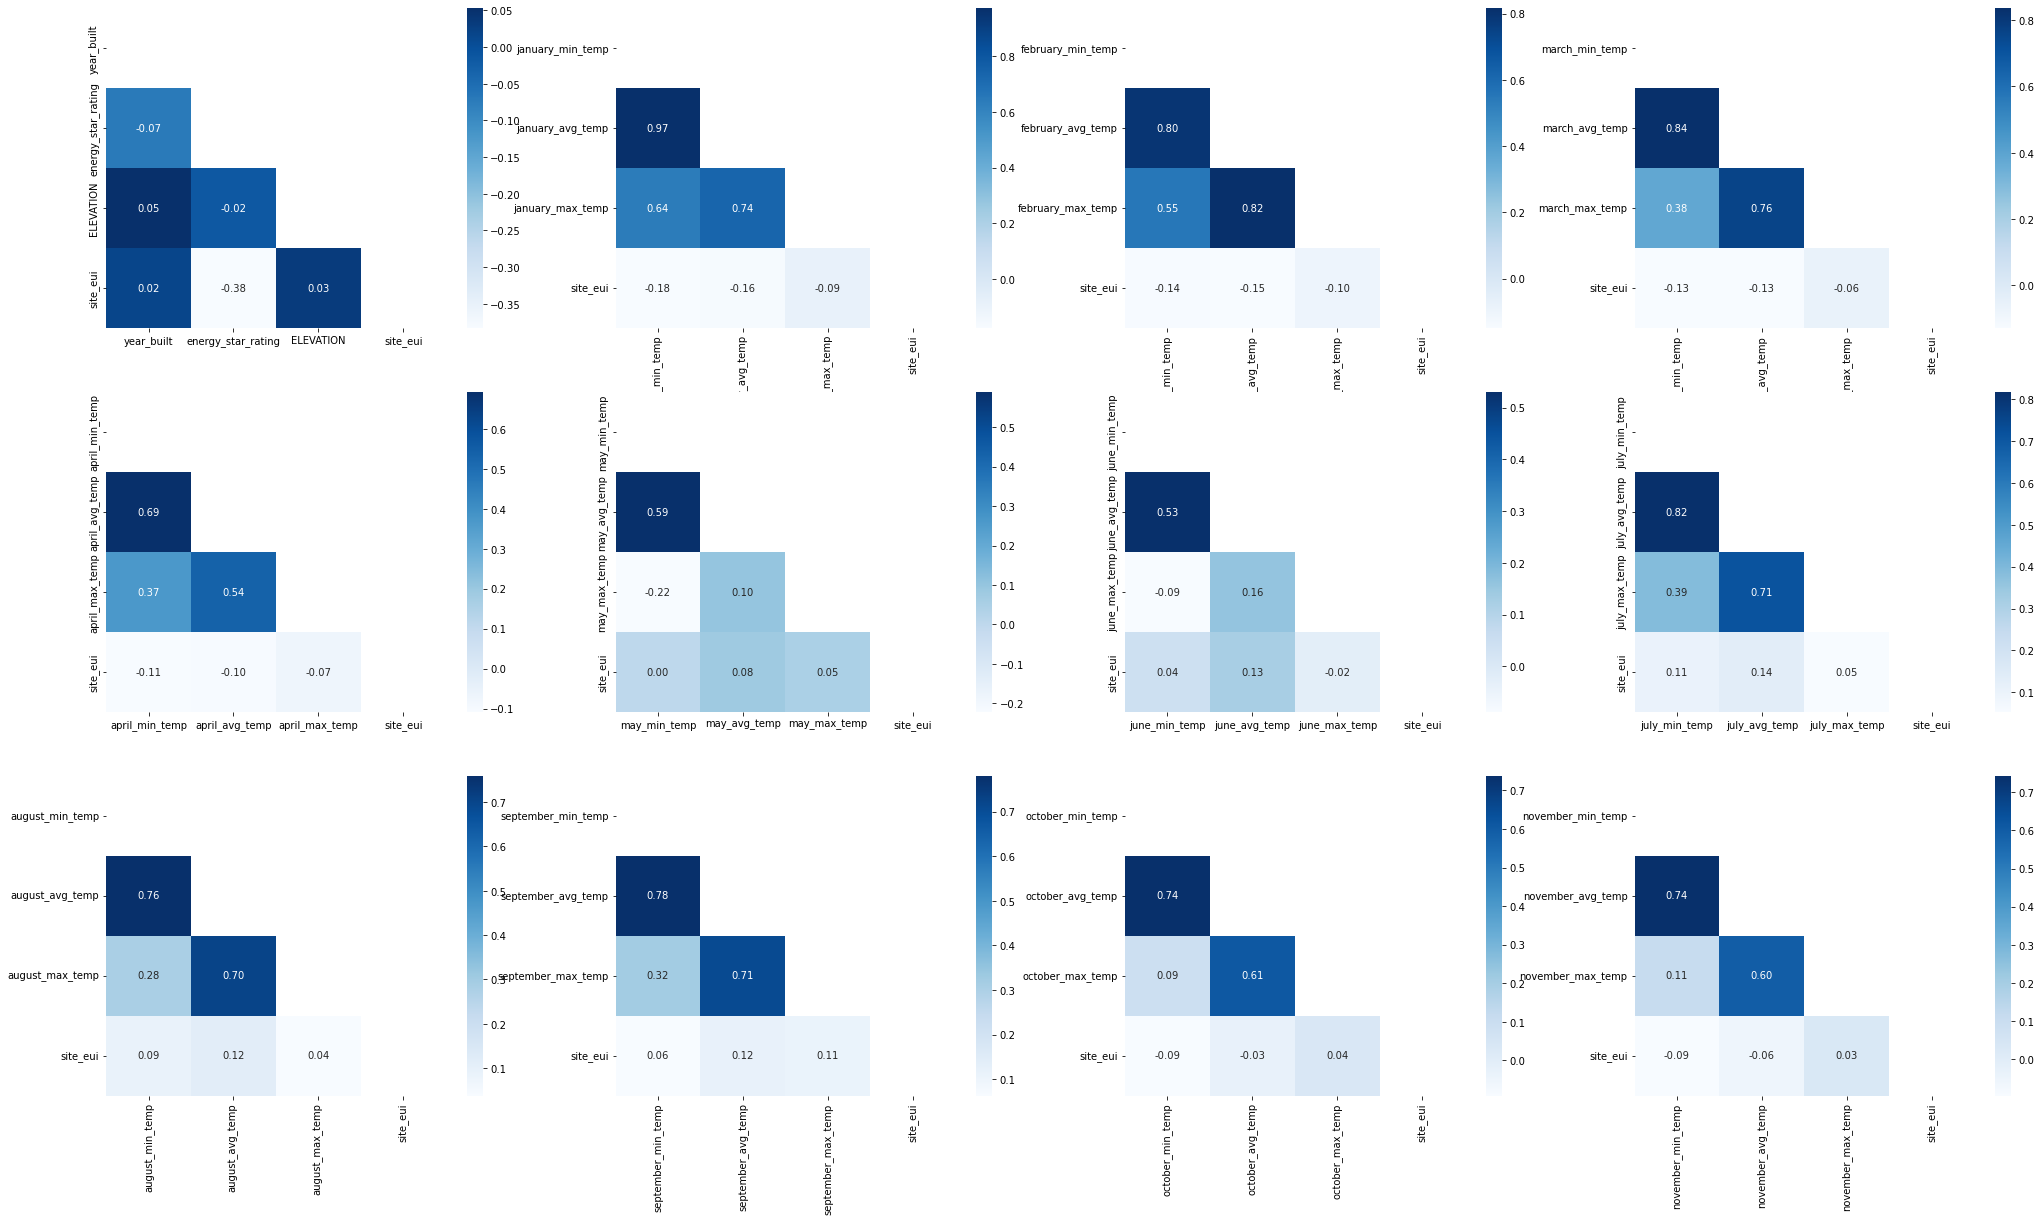

In [45]:
fig, ax = plt.subplots(3,4,figsize=(35,20))
months = train_csv.iloc[: , 5:41].columns.tolist()
count1 = 0
count2 = 0
fInd = 5
sInd = 8
for pic in range(len(months)//3):
    month_corr = pd.concat([train_csv.iloc[: , fInd:sInd], train_csv['site_eui']], axis=1).corr()
    matrix = np.triu(month_corr)
    sns.heatmap(month_corr, annot=True , mask=matrix , fmt='.2f' ,cmap="Blues" ,ax=ax[count1, count2])
    fInd=sInd
    sInd+=3
    count2+=1
    if pic in [3,7,11]:
        count1+=1
        count2=0

months:  ['january_min_temp', 'january_avg_temp', 'january_max_temp', 'february_min_temp', 'february_avg_temp', 'february_max_temp', 'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp', 'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp', 'august_max_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'october_min_temp', 'october_avg_temp', 'october_max_temp', 'november_min_temp', 'november_avg_temp', 'november_max_temp', 'december_min_temp', 'december_avg_temp', 'december_max_temp']


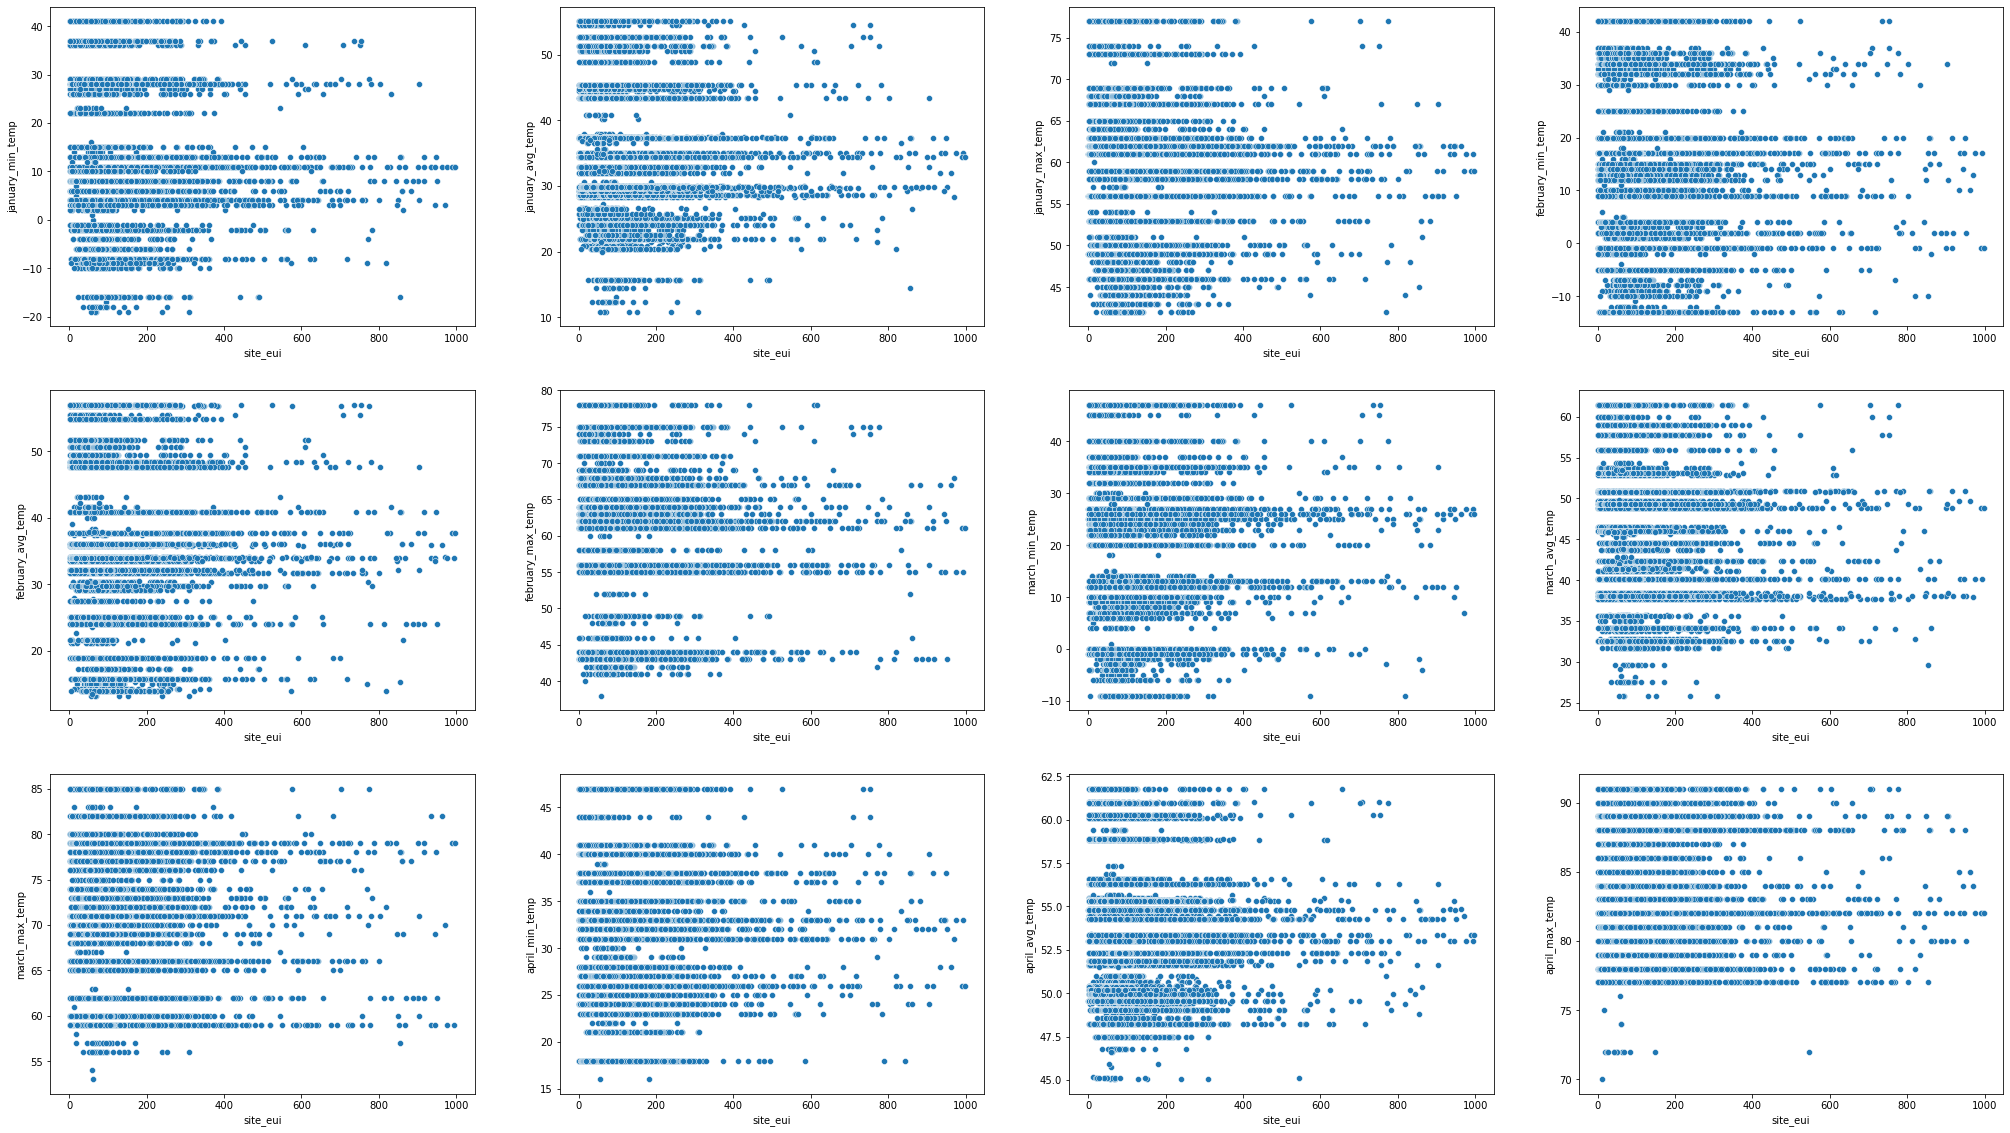

In [46]:
fig, ax = plt.subplots(3,4,figsize=(35,20))
months = train_csv.iloc[: , 8:44].columns.tolist()
count1 = 0
count2 = 0
print('months: ', months )
for pic in months:
    sns.scatterplot(data=train_csv, x=train_csv['site_eui'], y=train_csv[pic] ,ax=ax[count1, count2])
    count2+=1
    if months.index(pic) in [3,7, 11]:
        count1+=1
        count2=0
    if count1 == 3:
        break

#### Notes: #### 
- (0) Celsius = (32) Fahrenheit
- (0) Fahrenheit = (-17.78) Celsius
- from Fahrenheit to Celsius:> celsius = (Fahrenheit - 32) * (5/9)

### Part 3 ###
- Below:
    'days_below_30F', 'days_below_20F',
    'days_below_10F', 'days_below_0F'
- Above:
    'days_above_80F', 'days_above_90F',
    'days_above_100F', 'days_above_110F'

In [47]:
train_csv[['days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_0F']].describe().T

count       mean        std  min   25%   50%   75%    max
days_below_30F  73914.0  49.220513  27.419524  0.0  22.0  50.0  66.0  137.0
days_below_20F  73914.0  17.688530  14.480531  0.0   5.0  11.0  26.0   93.0
days_below_10F  73914.0   4.968612   7.115870  0.0   0.0   2.0   7.0   59.0
days_below_0F   73914.0   0.896677   2.923719  0.0   0.0   0.0   0.0   31.0

In [48]:
train_csv[['days_above_80F', 'days_above_90F', 'days_above_100F', 'days_above_110F']].describe().T

count       mean        std  min   25%   50%   75%    max
days_above_80F   73914.0  82.481857  24.551778  6.0  72.0  84.0  97.0  136.0
days_above_90F   73914.0  13.722881   9.549999  0.0   6.0  12.0  17.0   52.0
days_above_100F  73914.0   0.181576   1.195444  0.0   0.0   0.0   0.0   10.0
days_above_110F  73914.0   0.000000   0.000000  0.0   0.0   0.0   0.0    0.0

<AxesSubplot:>

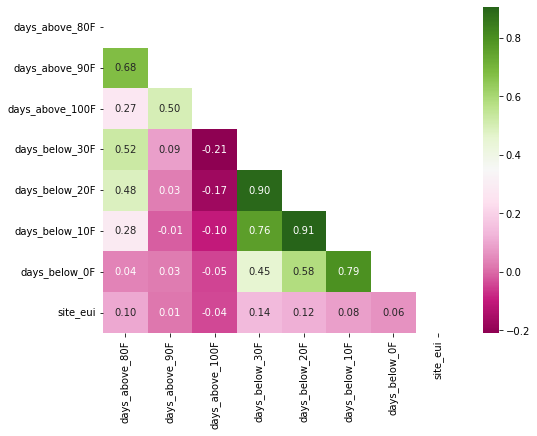

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
part3_corr = train_csv[['days_above_80F', 'days_above_90F', 'days_above_100F',
           'days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_0F', 'site_eui']].corr()
matrix = np.triu(part3_corr)
sns.heatmap(part3_corr, annot=True, fmt='.2f',cmap="PiYG", mask=matrix)

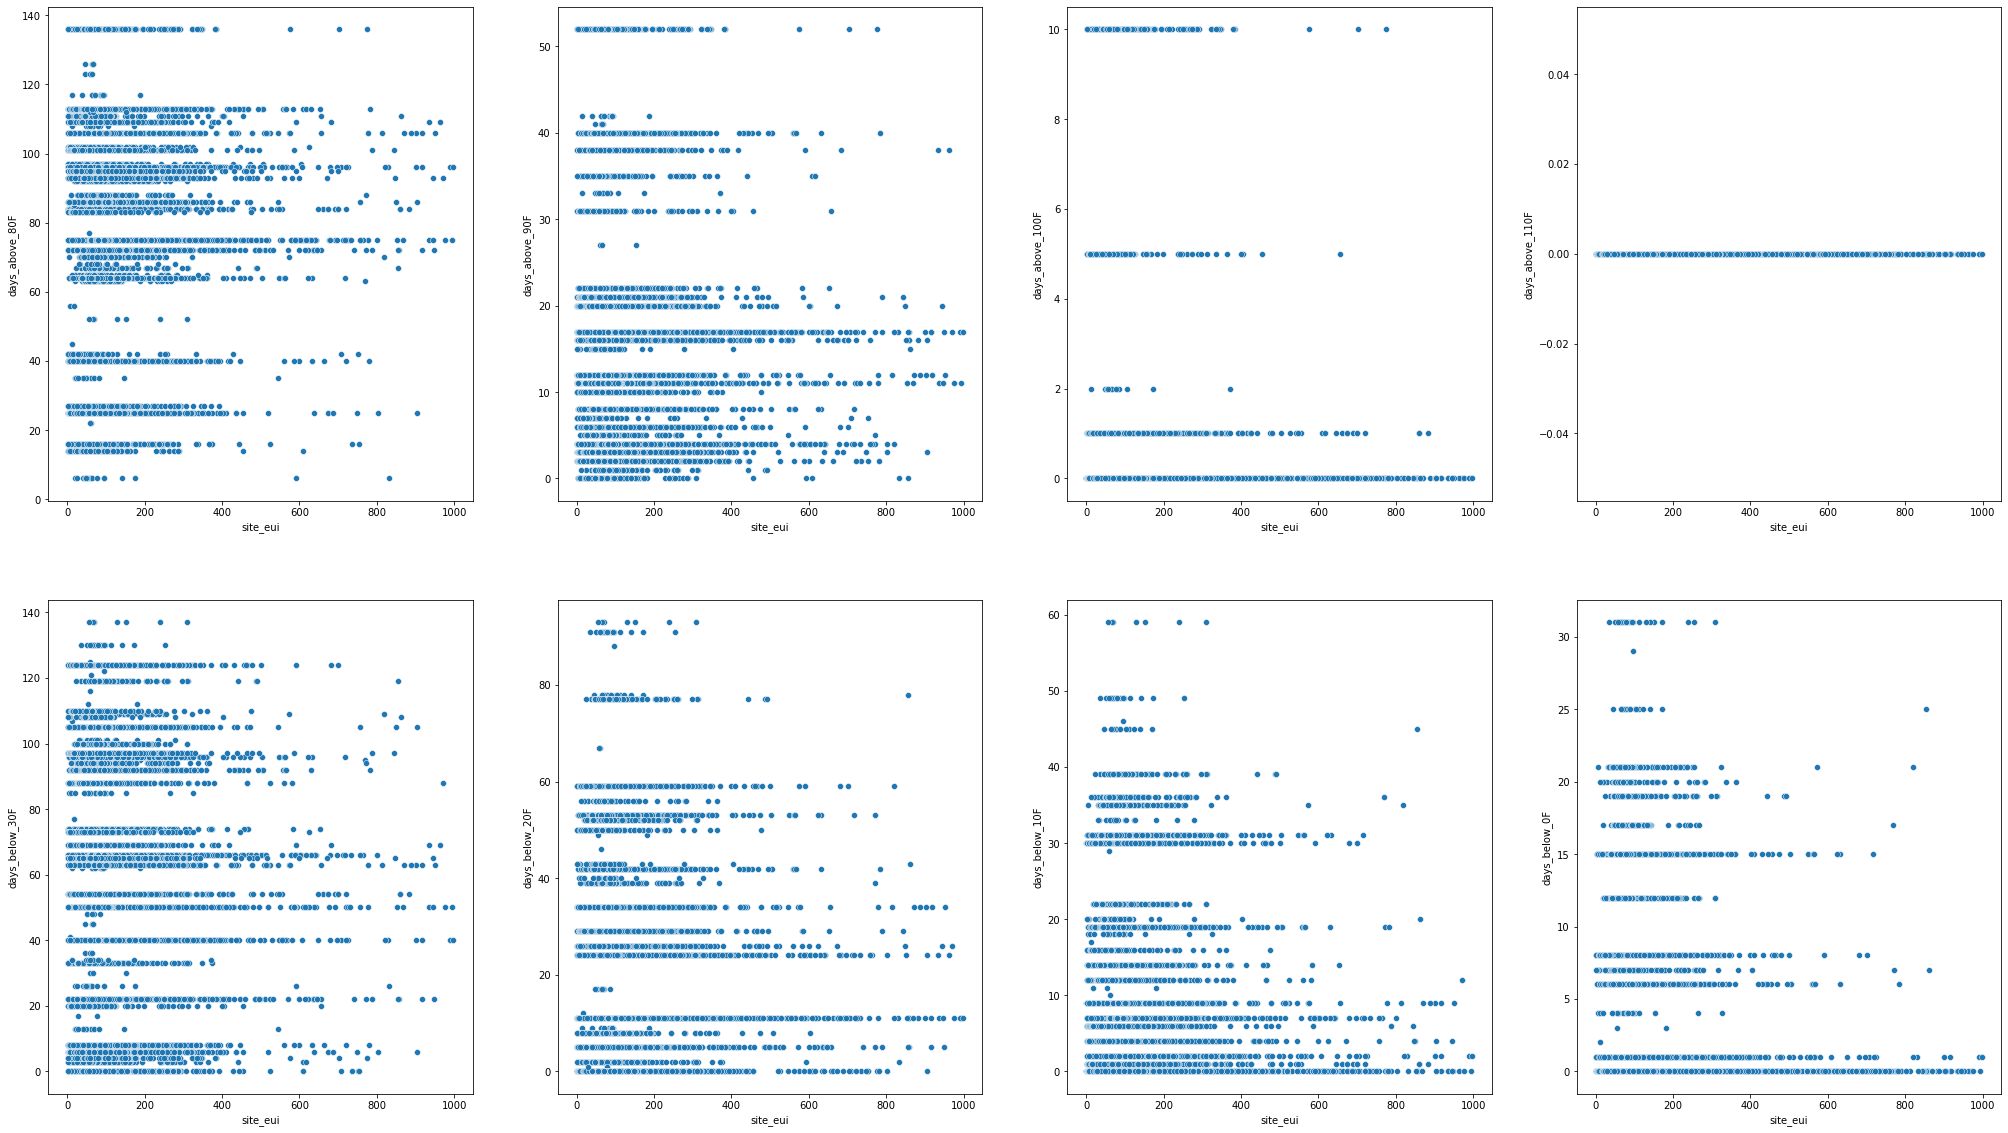

In [50]:
fig, ax = plt.subplots(2,4,figsize=(35,20))
part3_features = ['days_above_80F', 'days_above_90F', 'days_above_100F',
           'days_above_110F','days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_0F']
count1 = 0
count2 = 0
for pic in part3_features:
    sns.scatterplot(data=train_csv, x=train_csv['site_eui'], y=train_csv[pic] ,ax=ax[count1, count2])
    count2+=1
    if part3_features.index(pic) in [3,7]:
        count1+=1
        count2=0
    if count1 == 2:
        break

In [51]:
train_csv.drop(['days_above_90F', 'days_above_100F', 'days_below_20F', 'days_below_10F', 'days_below_0F'], axis=1, inplace=True)

In [52]:
train_csv.set_index('id', inplace=True)
train_csv.index.rename('', inplace=True)
train_csv.head()

Year_Factor State_Factor building_class  \
                                             
0            1      State_1     Commercial   
1            1      State_1     Commercial   
2            1      State_1     Commercial   
3            1      State_1     Commercial   
4            1      State_1     Commercial   

                               facility_type  floor_area  year_built  \
                                                                       
0               Grocery_store_or_food_market     61242.0        1942   
1  Warehouse_Distribution_or_Shipping_center    274000.0        1955   
2                       Retail_Enclosed_mall    280025.0        1951   
3                  Education_Other_classroom     55325.0        1980   
4                  Warehouse_Nonrefrigerated     66000.0        1985   

   energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  ...  \
                                                                      ...   
0                11.0        2.4                36              50.5  ...   
1                45.0        1.8                36              50.5  ...   
2                97.0        1.8                36              50.5  ...   
3                46.0        1.8                36              50.5  ...   
4               100.0        2.4                36              50.5  ...   

   snowdepth_inches   avg_temp  days_below_30F  days_above_80F  \
                                                                 
0                 0  56.972603               0              14   
1                 0  56.972603               0              14   
2                 0  56.972603               0              14   
3                 0  56.972603               0              14   
4                 0  56.972603               0              14   

   days_above_110F    site_eui  cooling_heating_degree_days  year_min_avg  \
                                                                            
0                0  248.682615                         3075     44.166667   
1                0   26.500150                         3075     44.166667   
2                0   24.693619                         3075     44.166667   
3                0   48.406926                         3075     44.166667   
4                0    3.899395                         3075     44.166667   

   year_avg_avg  year_max_avg  
                               
0     56.938758     79.833333  
1     56.938758     79.833333  
2     56.938758     79.833333  
3     56.938758     79.833333  
4     56.938758     79.833333  

[5 rows x 58 columns]

In [53]:
num_features = train_csv.drop(['State_Factor', 'building_class', 'facility_type'], axis=1).columns.tolist()
cat_features = ['State_Factor', 'building_class', 'facility_type']

### Remove the outliers using IQR ###

In [54]:
# def detect_outLier_features(df, features):
#     for feature in features:
#         q1 = np.quantile(df[feature], 0.25, interpolation='midpoint')
#         q3 = np.quantile(df[feature], 0.75, interpolation='midpoint')
#         IQR = q3 - q1
#         upper_outlier = q3 + (3.5 * IQR)
#         lower_outlier = q1 - (3.5 * IQR)
#         print(str(feature)+' IQR :', IQR)
#         print(str(feature)+' Upper Outlier :', upper_outlier)
#         print(str(feature)+' Lower Outlier :', lower_outlier)
#         print('==============================================')
# detect_outLier_features(train_csv, num_features)

In [55]:
def detect_outLier_df(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    new_df = df[~((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return new_df


In [56]:
sub_data = train_csv[num_features]
print(sub_data.shape)
sub_data.head(5)

(73914, 55)


Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
                                                                        
0            1     61242.0        1942                11.0        2.4   
1            1    274000.0        1955                45.0        1.8   
2            1    280025.0        1951                97.0        1.8   
3            1     55325.0        1980                46.0        1.8   
4            1     66000.0        1985               100.0        2.4   

   january_min_temp  january_avg_temp  january_max_temp  february_min_temp  \
                                                                             
0                36              50.5                68                 35   
1                36              50.5                68                 35   
2                36              50.5                68                 35   
3                36              50.5                68                 35   
4                36              50.5                68                 35   

   february_avg_temp  ...  snowdepth_inches   avg_temp  days_below_30F  \
                      ...                                                
0          50.589286  ...                 0  56.972603               0   
1          50.589286  ...                 0  56.972603               0   
2          50.589286  ...                 0  56.972603               0   
3          50.589286  ...                 0  56.972603               0   
4          50.589286  ...                 0  56.972603               0   

   days_above_80F  days_above_110F    site_eui  cooling_heating_degree_days  \
                                                                              
0              14                0  248.682615                         3075   
1              14                0   26.500150                         3075   
2              14                0   24.693619                         3075   
3              14                0   48.406926                         3075   
4              14                0    3.899395                         3075   

   year_min_avg  year_avg_avg  year_max_avg  
                                             
0     44.166667     56.938758     79.833333  
1     44.166667     56.938758     79.833333  
2     44.166667     56.938758     79.833333  
3     44.166667     56.938758     79.833333  
4     44.166667     56.938758     79.833333  

[5 rows x 55 columns]

In [57]:
new_df = detect_outLier_df(sub_data)
new_df.head()

Year_Factor  floor_area  year_built  energy_star_rating  ELEVATION  \
                                                                        
0            1     61242.0      1942.0                 NaN        2.4   
1            1    274000.0      1955.0                45.0        1.8   
2            1    280025.0      1951.0                97.0        1.8   
3            1     55325.0      1980.0                46.0        1.8   
4            1     66000.0      1985.0               100.0        2.4   

   january_min_temp  january_avg_temp  january_max_temp  february_min_temp  \
                                                                             
0               NaN               NaN              68.0                 35   
1               NaN               NaN              68.0                 35   
2               NaN               NaN              68.0                 35   
3               NaN               NaN              68.0                 35   
4               NaN               NaN              68.0                 35   

   february_avg_temp  ...  snowdepth_inches   avg_temp  days_below_30F  \
                      ...                                                
0          50.589286  ...                 0  56.972603             0.0   
1          50.589286  ...                 0  56.972603             0.0   
2          50.589286  ...                 0  56.972603             0.0   
3          50.589286  ...                 0  56.972603             0.0   
4          50.589286  ...                 0  56.972603             0.0   

   days_above_80F  days_above_110F   site_eui  cooling_heating_degree_days  \
                                                                             
0             NaN                0        NaN                          NaN   
1             NaN                0  26.500150                          NaN   
2             NaN                0  24.693619                          NaN   
3             NaN                0  48.406926                          NaN   
4             NaN                0   3.899395                          NaN   

   year_min_avg  year_avg_avg  year_max_avg  
                                             
0     44.166667     56.938758     79.833333  
1     44.166667     56.938758     79.833333  
2     44.166667     56.938758     79.833333  
3     44.166667     56.938758     79.833333  
4     44.166667     56.938758     79.833333  

[5 rows x 55 columns]

In [58]:
print('The number of Null Values: ', sum(new_df.isnull().sum().tolist()))

The number of Null Values:  238345


In [59]:
attrib = list(sub_data)
def remove_outLier_from_data(df):
    for i in attrib:
        df_outlier_removed = detect_outLier_df(df[i])
        df_outlier_removed = pd.DataFrame(df_outlier_removed)
        ind_diff=df.index.difference(df_outlier_removed.index)
        # print(i, ': ', len(ind_diff))
        for j in range(0, len(ind_diff), 1):
            final_df = df.drop([ind_diff[j]])
            df = final_df
    return df

In [60]:
train_data = remove_outLier_from_data(train_csv)

In [61]:
print(train_data.shape)
train_data.isnull().sum()

(23002, 58)


Year_Factor                    0
State_Factor                   0
building_class                 0
facility_type                  0
floor_area                     0
year_built                     0
energy_star_rating             0
ELEVATION                      0
january_min_temp               0
january_avg_temp               0
january_max_temp               0
february_min_temp              0
february_avg_temp              0
february_max_temp              0
march_min_temp                 0
march_avg_temp                 0
march_max_temp                 0
april_min_temp                 0
april_avg_temp                 0
april_max_temp                 0
may_min_temp                   0
may_avg_temp                   0
may_max_temp                   0
june_min_temp                  0
june_avg_temp                  0
june_max_temp                  0
july_min_temp                  0
july_avg_temp                  0
july_max_temp                  0
august_min_temp                0
august_avg

### Categorical Features: ###
- ['facility_type', 'State_Factor', 'building_class']

In [62]:
train_data[['facility_type', 'State_Factor', 'building_class']].describe(include='O')

facility_type State_Factor building_class
count                       23002        23002          23002
unique                         42            1              2
top     Multifamily_Uncategorized      State_6    Residential
freq                        17457        23002          17555

<AxesSubplot:xlabel='State_Factor', ylabel='count'>

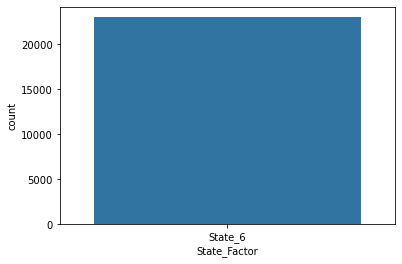

In [63]:
sns.countplot(data=train_data, x=train_data['State_Factor'])

In [64]:
train_data.drop('State_Factor', axis=1, inplace=True)

<AxesSubplot:xlabel='count', ylabel='facility_type'>

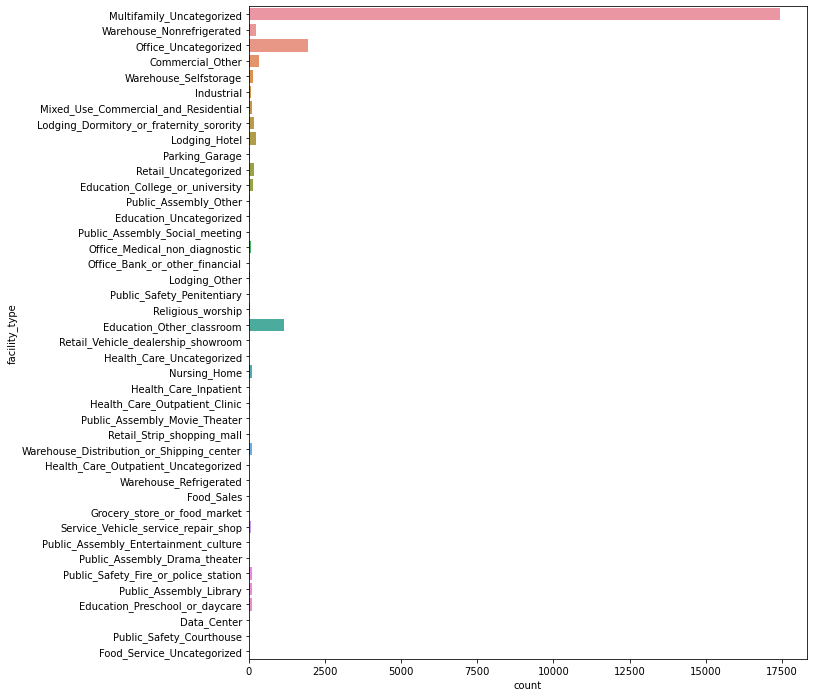

In [65]:
fig, ax = plt.subplots(figsize=(10,12))
sns.countplot(data=train_data, y=train_data['facility_type'])

In [66]:
train_data.building_class.value_counts()

Residential    17555
Commercial      5447
Name: building_class, dtype: int64

<AxesSubplot:xlabel='building_class', ylabel='count'>

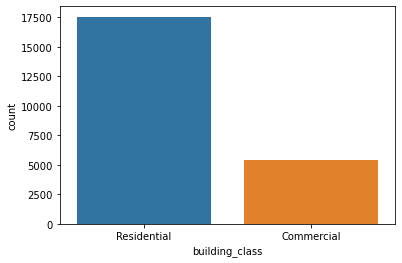

In [67]:
sns.countplot(data=train_data, x=train_data['building_class'])

In [68]:
B_encoder = BinaryEncoder(cols=['facility_type'],return_df=True)
facility_encoded = B_encoder.fit_transform(train_data)
Hot_encoder = OneHotEncoder(cols='building_class',handle_unknown='return_nan',return_df=True,use_cat_names=True)
train_data = Hot_encoder.fit_transform(facility_encoded)

In [69]:
train_data.head()

Year_Factor  building_class_Residential  building_class_Commercial  \
                                                                            
16535            2                         1.0                        0.0   
16536            2                         0.0                        1.0   
16537            2                         0.0                        1.0   
16538            2                         0.0                        1.0   
16539            2                         0.0                        1.0   

       facility_type_0  facility_type_1  facility_type_2  facility_type_3  \
                                                                            
16535                0                0                0                0   
16536                0                0                0                0   
16537                0                0                0                0   
16538                0                0                0                0   
16539                0                0                0                1   

       facility_type_4  facility_type_5  floor_area  ...  snowdepth_inches  \
                                                     ...                     
16535                0                1    107255.0  ...                10   
16536                1                0    229100.0  ...                10   
16537                1                1     90646.0  ...                10   
16538                1                1    108000.0  ...                10   
16539                0                0    218019.0  ...                10   

       avg_temp  days_below_30F  days_above_80F  days_above_110F    site_eui  \
                                                                               
16535  57.36612              22              72                0  121.008211   
16536  57.36612              22              72                0   15.762666   
16537  57.36612              22              72                0   48.267760   
16538  57.36612              22              72                0   60.325633   
16539  57.36612              22              72                0   53.220524   

       cooling_heating_degree_days  year_min_avg  year_avg_avg  year_max_avg  
                                                                              
16535                         5255          39.0     57.301546     80.083333  
16536                         5255          39.0     57.301546     80.083333  
16537                         5255          39.0     57.301546     80.083333  
16538                         5255          39.0     57.301546     80.083333  
16539                         5255          39.0     57.301546     80.083333  

[5 rows x 63 columns]

In [70]:
train_data['building_class'] = train_data.building_class_Commercial
train_data.drop(['building_class_Commercial', 'building_class_Residential'], axis=1, inplace=True)

In [71]:
train_data.drop('days_above_110F', axis=1, inplace=True)

### Feature Selection ###

<AxesSubplot:>

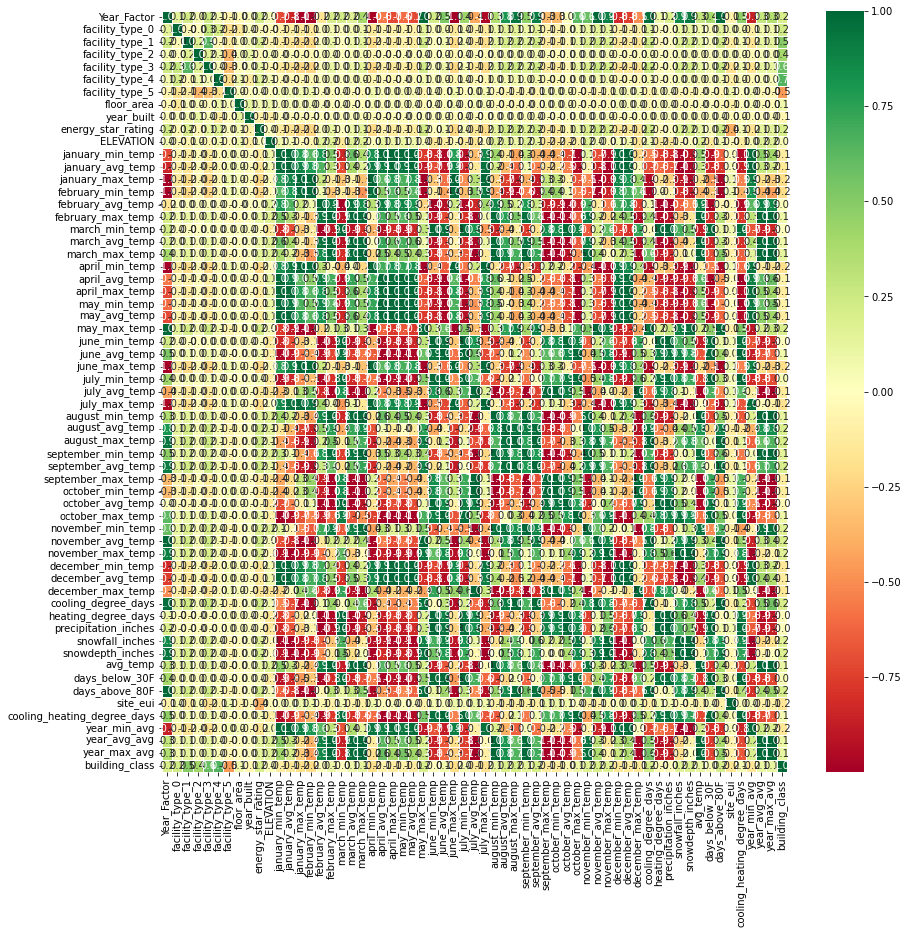

In [72]:
Corr_matrix = train_data.corr()
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(Corr_matrix, annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap="RdYlGn")

In [73]:
Target = train_data['site_eui'].copy()
train = train_data.drop('site_eui', axis=1)
# print('Train Before  VarianceThreshold: ',train.shape)
#===================================================
# vt = VarianceThreshold(threshold=0)
# high_variance_data = vt.fit_transform(train)
# train = pd.DataFrame(high_variance_data)
# print('Train After  VarianceThreshold: ',train.shape)
#====================================================
# importances = mutual_info_regression(train, Target)
# feat_importances = pd.Series(importances, train.columns[0:len(train.columns)])

# f,ax = plt.subplots(figsize=(12, 19))
# feat_importances.plot(kind="barh", color = 'teal')
# plt.show()

# sel_ = SelectKBest(mutual_info_regression, k=10).fit_transform(train, Target)
# final_train = pd.DataFrame(sel_)
#=====================================================
train.drop('year_built', axis=1, inplace=True)
def correlation(data, threshold=None):
    # Set of all names of correlated columns
    col_corr = set()
    corr_mat = data.corr()
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if (abs(corr_mat.iloc[i,j]) > threshold):
                colname = corr_mat.columns[i]
                col_corr.add(colname)
    return col_corr
correlated_features = list(correlation(train,threshold=0.6))
# print(len(train_data.drop('site_eui', axis=1).iloc[: , correlated_features].columns.tolist()))
final_train = train.drop(correlated_features, axis=1)

<AxesSubplot:>

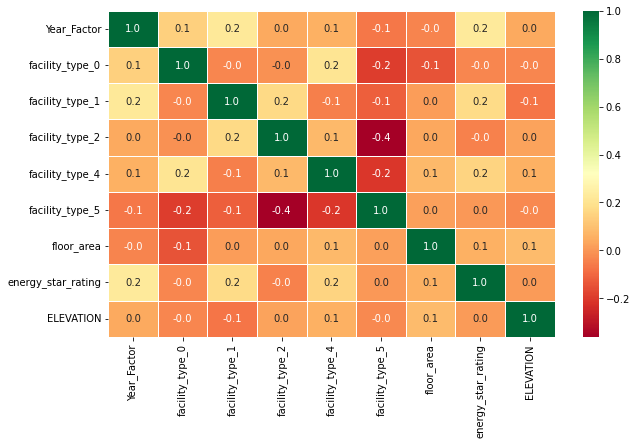

In [74]:

f,ax = plt.subplots(figsize=(10, 6))
sns.heatmap(final_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap="RdYlGn")

In [75]:
final_train.reset_index(drop=True, inplace=True)

In [76]:
final_train

Year_Factor  facility_type_0  facility_type_1  facility_type_2  \
0                2                0                0                0   
1                2                0                0                0   
2                2                0                0                0   
3                2                0                0                0   
4                2                0                0                0   
...            ...              ...              ...              ...   
22997            6                0                0                0   
22998            6                0                0                0   
22999            6                0                0                0   
23000            6                0                0                1   
23001            6                0                0                0   

       facility_type_4  facility_type_5  floor_area  energy_star_rating  \
0                    0                1    107255.0           61.042445   
1                    1                0    229100.0           99.000000   
2                    1                1     90646.0           87.000000   
3                    1                1    108000.0           61.042445   
4                    0                0    218019.0           61.042445   
...                ...              ...         ...                 ...   
22997                0                1    175726.0           93.000000   
22998                0                1    139416.0           66.000000   
22999                0                1    149653.0           67.000000   
23000                0                0    131979.0           61.042445   
23001                0                1     97850.0           88.000000   

       ELEVATION  
0           42.7  
1           42.7  
2           42.7  
3           42.7  
4           42.7  
...          ...  
22997       24.4  
22998       24.4  
22999       24.4  
23000       24.4  
23001       24.4  

[23002 rows x 9 columns]

### Trying Models ###

In [77]:
train, valid, target, valid_target = train_test_split(final_train, Target, test_size = 0.2)

In [78]:
lasso = Lasso()
lasso_model = TransformedTargetRegressor(regressor= lasso,
                                        transformer = MinMaxScaler()
                                        ).fit(train, target)
lasso_pre = lasso_model.predict(valid)

In [79]:
lasso_mse = mean_squared_error(valid_target, lasso_pre)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mae = mean_absolute_error(valid_target, lasso_pre)
print('RMSE for lasso predictions: ', lasso_rmse)
print('MAE for lasso predictions: ', lasso_mae)

RMSE for lasso predictions:  24.308240880178516
MAE for lasso predictions:  18.78849047434967


In [80]:
dst = DecisionTreeRegressor()
dst_model = TransformedTargetRegressor(regressor= dst,
                                        transformer = MinMaxScaler()
                                        ).fit(train, target)
dst_pre = dst_model.predict(valid)

In [81]:
dst_mse = mean_squared_error(valid_target, dst_pre)
dst_rmse = np.sqrt(dst_mse)
dst_mae = mean_absolute_error(valid_target, dst_pre)
print('RMSE for DecisionTreeRegressor predictions: ', dst_rmse)
print('MAE for DecisionTreeRegressor predictions: ', dst_mae)

RMSE for DecisionTreeRegressor predictions:  28.595629850534326
MAE for DecisionTreeRegressor predictions:  21.29300260015269


In [82]:
lgbm =lightgbm.LGBMRegressor()
lgbm_model = TransformedTargetRegressor(regressor= lgbm,
                                        transformer = MinMaxScaler()
                                        ).fit(train, target)
lgbm_pre = lgbm_model.predict(valid)

In [83]:
lgbm_mse = mean_squared_error(valid_target, lgbm_pre)
lgbm_rmse = np.sqrt(lgbm_mse)
lgbm_mae = mean_absolute_error(valid_target, lgbm_pre)
print('RMSE for LGBMRegressor predictions: ', lgbm_rmse)
print('MAE for LGBMRegressor predictions: ', lgbm_mae)

RMSE for LGBMRegressor predictions:  20.889301953082246
MAE for LGBMRegressor predictions:  15.50115798402031


In [84]:
ran = RandomForestRegressor()
ran_model = TransformedTargetRegressor(regressor= ran,
                                        transformer = MinMaxScaler()
                                        ).fit(train, target)
ran_pre = ran_model.predict(valid)

In [85]:
ran_mse = mean_squared_error(valid_target, ran_pre)
ran_rmse = np.sqrt(ran_mse)
ran_mae = mean_absolute_error(valid_target, ran_pre)
print('RMSE for RandomForest predictions: ', ran_rmse)
print('MAE for RandomForest predictions: ', ran_mae)

RMSE for RandomForest predictions:  22.771734499442626
MAE for RandomForest predictions:  16.989004581341227


### Test Data ###

In [86]:

print('Test data Shape: ', test_csv.shape)
print(test_csv.isnull().sum().sort_values(ascending=False))
test_csv.drop(['days_with_fog', 'max_wind_speed', 'direction_peak_wind_speed', 'direction_max_wind_speed', 'year_built'], axis=1, inplace=True)
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer.fit(test_csv[['energy_star_rating']])
test_csv['energy_star_rating'] = imputer.transform(test_csv[['energy_star_rating']])
test_csv['cooling_heating_degree_days']= test_csv['cooling_degree_days']+test_csv['heating_degree_days']

Test data Shape:  (9705, 63)
days_with_fog                9117
max_wind_speed               8575
direction_peak_wind_speed    8575
direction_max_wind_speed     8575
energy_star_rating           2254
                             ... 
july_avg_temp                   0
july_max_temp                   0
august_min_temp                 0
august_avg_temp                 0
id                              0
Length: 63, dtype: int64


In [87]:
test_csv['year_min_avg']= (test_csv['january_min_temp']+ test_csv['february_min_temp']+ test_csv['march_min_temp']+
           test_csv['april_min_temp']+ test_csv['may_min_temp']+ test_csv['june_min_temp']+
           test_csv['july_min_temp']+ test_csv['august_min_temp']+ test_csv['september_min_temp']+
           test_csv['october_min_temp']+ test_csv['november_min_temp']+ test_csv['december_min_temp'])/12
test_csv['year_avg_avg']= (test_csv['january_avg_temp']+test_csv['february_avg_temp']+test_csv['march_avg_temp']+ 
test_csv['april_avg_temp']+test_csv['may_avg_temp']+test_csv['june_avg_temp']+
test_csv['july_avg_temp']+test_csv['august_avg_temp']+test_csv['september_avg_temp']+
test_csv['october_avg_temp']+test_csv['november_avg_temp']+test_csv['december_avg_temp'])/12
test_csv['year_max_avg']=(test_csv['january_max_temp']+ test_csv['february_max_temp']+ test_csv['march_max_temp']+
           test_csv['april_max_temp']+ test_csv['may_max_temp']+ test_csv['june_max_temp']+
           test_csv['july_max_temp']+  test_csv['august_max_temp']+ test_csv['september_max_temp']+
           test_csv['october_max_temp']+ test_csv['november_max_temp']+ test_csv['december_max_temp'])/12
test_csv.drop(['days_above_90F', 'days_above_100F', 'days_above_110F','days_below_20F', 'days_below_10F', 'days_below_0F'], axis=1, inplace=True)
test_csv.set_index('id', inplace=True)
num_features = test_csv.drop(['State_Factor', 'building_class', 'facility_type'], axis=1).columns.tolist()
cat_features = ['State_Factor', 'building_class', 'facility_type']
# scaler = MinMaxScaler()
# scaled_num_data = scaler.fit_transform(test_csv[num_features])
# scaled_df = pd.DataFrame(scaled_num_data, index=test_csv.index ,columns=num_features)
# test_csv = pd.concat([scaled_df, test_csv[cat_features]], axis=1)
test_csv.index.rename('', inplace=True)

In [88]:
# def detect_outLier_df(df):
#     q1 = df.quantile(0.25)
#     q3 = df.quantile(0.75)
#     IQR = q3 - q1
#     new_df = df[~((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
#     return new_df
# sub_data = test_csv[num_features]
# attrib = list(sub_data)
# def remove_outLier_from_data(df):
#     for i in attrib:
#         df_outlier_removed = detect_outLier_df(df[i])
#         df_outlier_removed = pd.DataFrame(df_outlier_removed)
#         ind_diff=df.index.difference(df_outlier_removed.index)
#         for j in range(0, len(ind_diff), 1):
#             final_df = df.drop([ind_diff[j]])
#             df = final_df
#     return df
test_data = test_csv.copy()
print('Test data shape after detect the outliers: ', test_data.shape)

Test data shape after detect the outliers:  (9705, 55)


In [89]:
test_data[['facility_type', 'State_Factor', 'building_class']].describe(include='O')

facility_type State_Factor building_class
count                        9705         9705           9705
unique                         60            6              2
top     Multifamily_Uncategorized     State_11     Commercial
freq                         2199         3268           5607

In [90]:
test_data.State_Factor.value_counts()
test_data.drop('State_Factor', axis=1, inplace=True)

In [91]:
B_encoder = BinaryEncoder(cols=['facility_type'],return_df=True)
facility_encoded = B_encoder.fit_transform(test_data)
Hot_encoder = OneHotEncoder(cols='building_class',handle_unknown='return_nan',return_df=True,use_cat_names=True)
test_data = Hot_encoder.fit_transform(facility_encoded)

In [92]:
test_data['building_class'] = test_data.building_class_Commercial
test_data.drop(['building_class_Commercial', 'building_class_Residential'], axis=1, inplace=True)
final_test_data = test_data.drop(correlated_features, axis=1)
final_test_data.reset_index(drop=True, inplace=True)
print('Test data shape after feature selection: ', final_test_data.shape)

Test data shape after feature selection:  (9705, 9)


In [93]:
final_test_data.head()

Year_Factor  facility_type_0  facility_type_1  facility_type_2  \
0            7                0                0                0   
1            7                0                0                0   
2            7                0                0                0   
3            7                0                0                0   
4            7                0                0                0   

   facility_type_4  facility_type_5  floor_area  energy_star_rating  ELEVATION  
0                0                1     28484.0                37.0        2.4  
1                0                1     21906.0                55.0       45.7  
2                0                1     16138.0                 1.0       59.1  
3                0                1     97422.0                34.0       35.4  
4                0                1     61242.0                35.0        1.8

### Tuning Lightgbm model ###

In [ ]:
lgbm = lightgbm.LGBMRegressor()
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
grid_params= {'max_depth':list(range(3, 12)),
              'objective':['root_mean_squared_error'],
              'num_leaves':list(range(20, 100, 2)),
              'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
              'n_estimators':n_estimators,
              'reg_lambda':list(range(0, 100, 5)),
              'reg_alpha':list(range(0, 100, 5)),
              'min_child_samples':list(range(20, 100 ,5))}
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=train, y=target)
random_search = RandomizedSearchCV(estimator = lgbm, param_distributions = grid_params, n_iter = 100, cv =gkf , verbose=2, random_state=42, n_jobs = -1)
random_search.fit(train, target)
print("Best Parameters:", random_search.best_params_)

In [95]:
final_model = random_search.best_estimator_

In [96]:
test_pre = final_model.predict(final_test_data)

In [97]:
test_pre[:10]

array([104.81626786,  93.41038302, 104.84877261,  86.25871889,
        90.41386671,  97.42148354, 101.22313325, 103.20492396,
        81.85008311,  93.92899432])

In [98]:
print('Range: (', test_pre.min(), ' - ', test_pre.max(), ')')

Range: ( 2.2977054130581918  -  131.02273451093433 )


### CSV Result ###

In [103]:
sample_solution['site_eui'] = test_pre

In [105]:
sample_solution.to_csv('sub.csv', index=False)